In [3]:
import torch
from family_training import FamilyShapeSDFWrapper, load_wrapper_from_dir
from models import SingleShapeSDF
import trimesh
import meshplot
import numpy as np
from mesh_to_sdf import sample_sdf_near_surface, scale_to_unit_sphere
from torch.utils.data import DataLoader, TensorDataset, random_split
from test_fnn import visualize_voxels_png


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cuda'

## Load mesh

In [5]:
mesh = trimesh.load('data/torus.obj')

In [6]:
p = meshplot.plot(mesh.vertices, mesh.faces, c=np.array(mesh.vertices)[:,1])

/home/ivan/anaconda3/envs/mydeepsdf/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "uint32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(
/home/ivan/anaconda3/envs/mydeepsdf/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(7.5995922…

## Sample points

In [7]:
# it will take time, I warn you

# points, sdf = sample_sdf_near_surface(mesh, number_of_points=300000)

# load points instead

with open('data/torus.npy', 'rb') as f:
    points = np.load(f)
    sdf = np.load(f)

In [8]:
mesh = scale_to_unit_sphere(mesh)
p = meshplot.plot(mesh.vertices, mesh.faces, filename="debug/test_pointsampling.html")
p.add_points(points, c=sdf,
                shading={"point_size": 0.08,
                         "alpha": 0.3,
                         "normalize": [True, True],
                         "colormap": "jet"})
p.add_points(points=np.array([[-0.5,0,0.5],[0.5,0,0.5]]), shading = {"point_size": 1})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

2

### (optional) Save points

In [9]:
# with open("data/torus.npy", 'wb') as f:
#     np.save(f, points)
#     np.save(f, sdf)

## Create model

In [10]:
model = SingleShapeSDF([512, 512, 512]).to(device)

print(model)

SingleShapeSDF(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)


### pytorch dataloaders + balanced sampling

In [8]:
features = torch.from_numpy(points)
labels = torch.from_numpy(sdf)
dataset = TensorDataset(features, labels)

sampling_weights = np.ones_like(sdf)
positive_part = np.sum(sdf>0) / sdf.shape[0]
negative_part = np.sum(sdf<0) / sdf.shape[0]
sampling_weights[sdf>0] = negative_part
sampling_weights[sdf<0] = positive_part

sampler = torch.utils.data.sampler.WeightedRandomSampler(sampling_weights, len(sampling_weights))         


train_loader = DataLoader(dataset,
                          batch_size=16384,
                          sampler = sampler,
                          num_workers=8)

#### Check that the sampling is balanced

In [9]:
iterat = iter(train_loader)
d1, l1 = next(iterat)

In [10]:
np.sum(l1.numpy()>0)

8093

In [11]:
np.sum(l1.numpy()<0)

8291

## Define loss function
$$\mathcal L (f_\theta(\mathbf x), s) = |\text{clamp}(f_\theta(\mathbf x), \delta) - \text{clamp}(s, \delta) |$$ 


$$\text{clamp}(x, \delta) = \min (\delta, \max (-\delta, x))$$

In [12]:
def deepsdfloss(outputs, targets, delta=0.1):
    return torch.mean(torch.abs(
        torch.clamp(outputs, min=-delta, max=delta) - torch.clamp(targets, min=-delta, max=delta)
    ))

### Training

In [13]:
n_epochs = 260
learning_rate=1e-4

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
t_history = []
for epoch in range(n_epochs):
    model.train(True)
    print(f"\nEpoch {epoch}")
    running_loss = 0
    total_loss = 0
    for i, data in enumerate(train_loader, 0):
        x, y = data[0].to(device), data[1].unsqueeze(1).to(device)
        y_pred = model(x)
        loss = deepsdfloss(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_loss += loss.item()
        if i % 5 == 4:
            print(i, running_loss)
            running_loss = 0

    t_history.append(total_loss)
    if epoch%5 == 4:
        visualize_voxels_png(model, filename=f"img/{epoch}.png")



Epoch 0
4 0.1219132300466299
9 0.09915955550968647
14 0.08877712301909924

Epoch 1
4 0.07582060806453228
9 0.07048375345766544
14 0.06520836148411036

Epoch 2
4 0.059208077378571033
9 0.056738863699138165
14 0.054058133624494076

Epoch 3
4 0.050444470718503
9 0.04806402791291475
14 0.04634778667241335

Epoch 4
4 0.04389785788953304
9 0.042688069865107536
14 0.04115263093262911

Epoch 5
4 0.03946436010301113
9 0.03889670129865408
14 0.03707480290904641

Epoch 6
4 0.036472000647336245
9 0.03531930549070239
14 0.035384722985327244

Epoch 7
4 0.033888854552060366
9 0.03298203181475401
14 0.03265635622665286

Epoch 8
4 0.031004230957478285
9 0.030809482093900442
14 0.029894547536969185

Epoch 9
4 0.0292602744884789
9 0.02785692224279046
14 0.027176034171134233

Epoch 10
4 0.02653433382511139
9 0.02589605003595352
14 0.02545527322217822

Epoch 11
4 0.024969941936433315
9 0.024356952868402004
14 0.02350978134199977

Epoch 12
4 0.023649574723094702
9 0.023253340739756823
14 0.0222429581917822

4 0.010266876313835382
9 0.010082672350108624
14 0.010195674607530236

Epoch 105
4 0.01016783295199275
9 0.00990901910699904
14 0.010204332415014505

Epoch 106
4 0.010191650595515966
9 0.01005947939120233
14 0.010139304678887129

Epoch 107
4 0.009987030527554452
9 0.01004606788046658
14 0.01004448113963008

Epoch 108
4 0.010091947391629219
9 0.009968435391783714
14 0.01018000312615186

Epoch 109
4 0.01004716893658042
9 0.010404546279460192
14 0.010596257634460926

Epoch 110
4 0.010289512109011412
9 0.010355187812820077
14 0.010337425163015723

Epoch 111
4 0.010295661399140954
9 0.010480831610038877
14 0.010397632839158177

Epoch 112
4 0.010263216565363109
9 0.010120985214598477
14 0.010173354297876358

Epoch 113
4 0.010034986771643162
9 0.01021020975895226
14 0.009915654780343175

Epoch 114
4 0.009937746450304985
9 0.010064061731100082
14 0.010432217037305236

Epoch 115
4 0.010186508065089583
9 0.010085703805088997
14 0.010254343040287495

Epoch 116
4 0.01014855457469821
9 0.0104826916

4 0.00923901132773608
9 0.008925053523853421
14 0.009207640192471445

Epoch 207
4 0.009084057761356235
9 0.009070869069546461
14 0.009266127366572618

Epoch 208
4 0.009230444673448801
9 0.009540352504700422
14 0.009504959103651345

Epoch 209
4 0.00911116087809205
9 0.009410409140400589
14 0.009155374835245311

Epoch 210
4 0.009160248679108918
9 0.009026985731907189
14 0.00924472522456199

Epoch 211
4 0.009201777051202953
9 0.009186228620819747
14 0.009263454237952828

Epoch 212
4 0.009280175203457475
9 0.009209913783706725
14 0.009084207005798817

Epoch 213
4 0.009127873228862882
9 0.009124403586611152
14 0.008952905656769872

Epoch 214
4 0.009195429156534374
9 0.009028091095387936
14 0.009428200661204755

Epoch 215
4 0.009547170833684504
9 0.009522665292024612
14 0.00928331189788878

Epoch 216
4 0.00912361906375736
9 0.00939279398880899
14 0.008939291350543499

Epoch 217
4 0.009362597716972232
9 0.008912601042538881
14 0.00899847864639014

Epoch 218
4 0.009117363370023668
9 0.00908316

In [15]:
torch.save(model.state_dict(), "chairSDF-512.pt")

### Loading

In [14]:
loadmodel = SingleShapeSDF([512, 512, 512]).to(device)
loadmodel.load_state_dict(torch.load("torusSDF-512.pt"))

<All keys matched successfully>

In [15]:
from test_fnn import visualize_marchingcubes, visualize_voxels

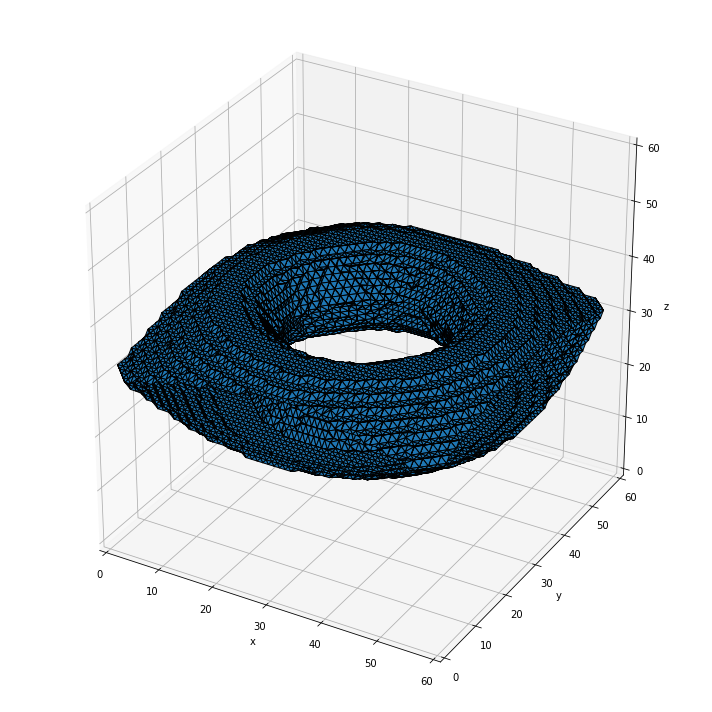

In [16]:
visualize_marchingcubes(loadmodel)

### Normals

In [64]:
point = np.float32([[-0.3,0,0]])


myxyz = torch.autograd.Variable(torch.from_numpy(point)).to(device)
myxyz.requires_grad = True
print(myxyz)
loadmodel.zero_grad()
l = loadmodel.forward(myxyz)

l.backward()

print(myxyz.grad)

In [58]:
point_end = point + myxyz.grad.cpu().numpy()

In [63]:
mesh = scale_to_unit_sphere(mesh)
p = meshplot.plot(mesh.vertices, mesh.faces, 
                  c=np.array(mesh.vertices)[:,1],
                  filename="debug/test_pointsampling.html")
p.add_lines(point, point_end, shading={"line_color": "red"})
p.add_points(point, shading = {"point_size": 1})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

2